In [2]:
from typing import Optional

import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt

In [3]:
def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:
  r"""Apply positional encoding to the input.

  Args:
    tensor (torch.Tensor): Input tensor to be positionally encoded.
    num_encoding_functions (optional, int): Number of encoding functions used to
        compute a positional encoding (default: 6).
    include_input (optional, bool): Whether or not to include the input in the
        computed positional encoding (default: True).
    log_sampling (optional, bool): Sample logarithmically in frequency space, as
        opposed to linearly (default: True).

  Returns:
    (torch.Tensor): Positional encoding of the input tensor.
  """
  # TESTED
  # Trivially, the input tensor is added to the positional encoding.
  encoding = [tensor] if include_input else []
  # Now, encode the input using a set of high-frequency functions and append the
  # resulting values to the encoding.
  frequency_bands = None
  if log_sampling:
      frequency_bands = 2.0 ** torch.linspace(
          0.0,
          num_encoding_functions - 1,
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
      )
  else:
      frequency_bands = torch.linspace(
          2.0 ** 0.0,
          2.0 ** (num_encoding_functions - 1),
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
      )

  for freq in frequency_bands:
      for func in [torch.sin, torch.cos]:
          encoding.append(func(tensor * freq))

  # Special case, for no positional encoding
  if len(encoding) == 1:
      return encoding[0]
  else:
      return torch.cat(encoding, dim=-1)


In [4]:
class VeryTinyNerfModel(torch.nn.Module):
  r"""Define a "very tiny" NeRF model comprising three fully connected layers.
  """

  def __init__(self, filter_size=256, num_encoding_functions=6, num_hidden_layers=8):
    super(VeryTinyNerfModel, self).__init__()
    # Input layer (default: 39 -> 256)
    self.input_layer = torch.nn.Linear(
        3 + 3 * 2 * num_encoding_functions, filter_size)
    # Hidden layers
    self.hidden_layers = []
    for i in range(num_hidden_layers):
      self.hidden_layers.append(torch.nn.Linear(filter_size, filter_size))
    # Output layer
    self.output_layer = torch.nn.Linear(filter_size, 3)
    # Short hand for torch.nn.functional.relu
    self.relu = torch.nn.functional.relu

  def forward(self, x):
    x = self.relu(self.input_layer(x))
    for hl in self.hidden_layers:
      x = self.relu(hl(x))
    x = self.output_layer(x)
    return x

In [5]:
def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
  r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
  Each element of the list (except possibly the last) has dimension `0` of length
  `chunksize`.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
cap = cv2.VideoCapture("../datasets/bunny/BigBuckBunny_320x180.mp4")
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)



def get_frame(idx):
  r""" Get the RGB tensor of a specific frame in the video.
  """
  cap.set(cv2.CAP_PROP_POS_MSEC, idx)
  success, img = cap.read()
  if not success:
    print("Failed to load frame at index " + str(idx))
  return torch.from_numpy(np.float32(img) / 255)


In [8]:
def xs_and_ys(width, height, frame_ind):
    r""" Construct (x, y, f) tuples.
    """
    res = []
    for y in range(height):
        for x in range(width):
            res.append([y, x, frame_ind])
    return torch.from_numpy(np.array(res))

In [9]:
def one_iter_npc(width, height, frame_ind, encoding_fn, get_minibatches_fn, chunksize):

  pts = xs_and_ys(width, height, frame_ind)

  encoded_pts = encoding_fn(pts)
  batches = get_minibatches_fn(encoded_pts, chunksize=chunksize)

  predictions = []
  for batch in batches:
    predictions.append(model(batch))
  
  rgb_flat = torch.cat(predictions, dim=0)
  rgb = torch.reshape(rgb_flat, [height, width, 3])
  return rgb

In [10]:
def output_video(total_frames, fps, width, height, encode, get_minibatches, chunksize):
  r"""Build the final video from the trained model."""
  out = cv2.VideoWriter('output_video.avi', cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))
  for f in range(total_frames):
      rgb_predicted = one_iter_npc(width, height,
                                   f, encode,
                                   get_minibatches, chunksize)
      out.write(rgb_predicted)
  
  out.release()

Loss: 0.4278576076030731


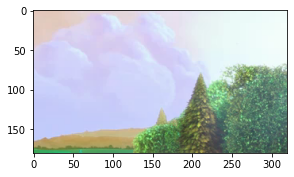

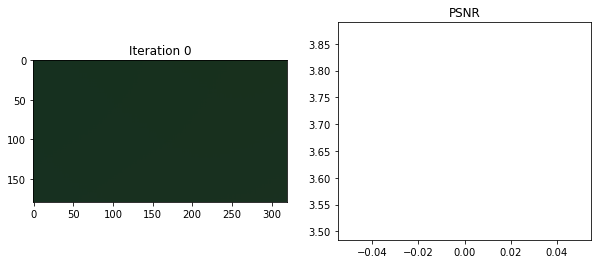

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 0.018015075474977493


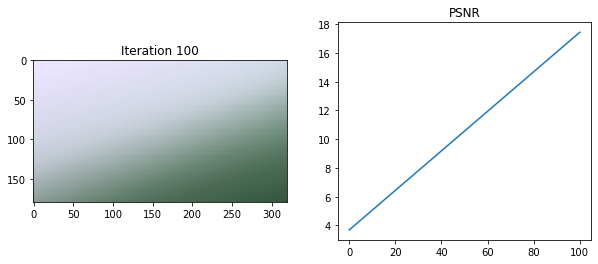

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 0.009487231262028217


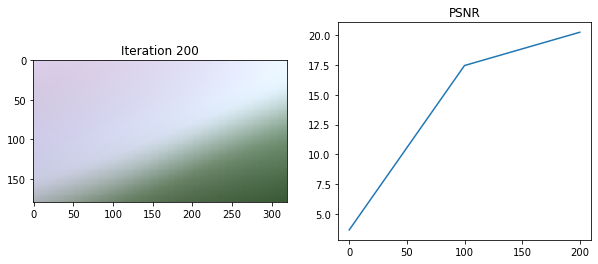

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 0.008699391037225723


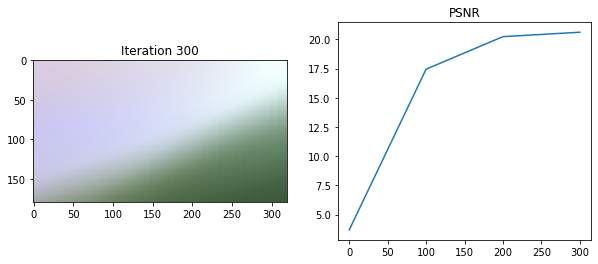

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 0.007749998476356268


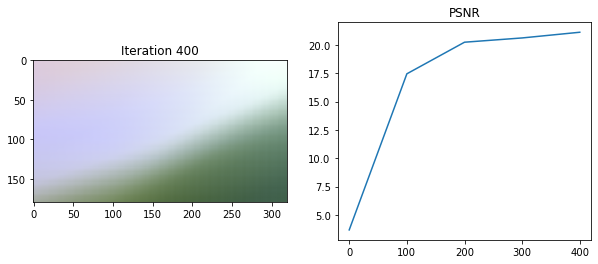

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: 0.0074504525400698185


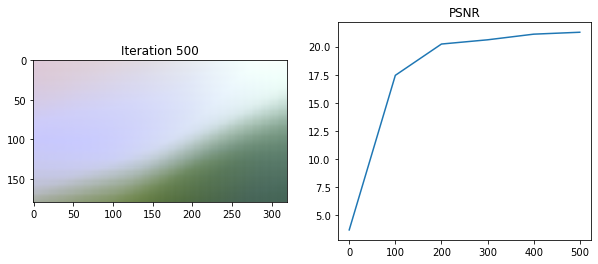

In [12]:
"""
Parameters for NPC training
"""

num_hidden_layers = 8
# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 6

# Specify encoding function.
def encode(x): return positional_encoding(
    x, num_encoding_functions=num_encoding_functions)

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
# Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.
chunksize = 16384 * 16

# Optimizer parameters
lr = 5e-3
num_iters = 50000

# Misc parameters
display_every = 500  # Number of iters after which stats are displayed

"""
Model
"""
model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions, num_hidden_layers=num_hidden_layers)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 1337
torch.manual_seed(seed)
np.random.seed(seed)

# Lists to log metrics etc.
psnrs = []
iternums = []

test_frame = 5000

start_frame = 5000
end_frame = int(5000 + (fps * 3))
total_frames = end_frame - start_frame

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.imshow(get_frame(test_frame))

for i in range(num_iters):

  # Randomly pick a frame as the target
  target_frame_idx = np.random.randint(start_frame, end_frame)
  target_img = get_frame(target_frame_idx)

  rgb_predicted = one_iter_npc(width, height,
                               target_frame_idx, encode,
                               get_minibatches, chunksize)

  # Compute mean-squared error between the predicted and target images. Backprop!
  loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Display images/plots/stats
  if i % display_every == 0:
    # Render the held-out view
    rgb_predicted = one_iter_npc(width, height,
                                test_frame, encode,
                                get_minibatches, chunksize)

    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    print("Loss:", loss.item())
    psnr = -10. * torch.log10(loss)

    psnrs.append(psnr.item())
    iternums.append(i)

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title(f"Iteration {i}")
    plt.subplot(122)
    plt.plot(iternums, psnrs)
    plt.title("PSNR")
    plt.show()

print('Done training. Storing output...')
output_video(total_frames, fps, width, height, encode, get_minibatches, chunksize)
